In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from scipy.stats import zscore
import squarify
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer



## Data Understanding

In [2]:
# Load the dataset
data = pd.read_csv(r"C:\Users\natal\OneDrive - MUNI\thesis\databaze.csv", sep=';')

df = pd.DataFrame(data)

df.head()

,total,currency,paid_at,user_id,md5(o.email)
0,17099.0,CZK,31.05.2021 22:18,NaN,10153fe7e517463e1a2784e9022e05e9
1,7099.0,CZK,31.05.2021 22:18,NaN,48a9fbe6ddce63cbf8179d0038c88457
2,9648.0,CZK,03.05.2021 8:07,NaN,7eb9c42c173a0a8caaa7c8d7ef0521b6
3,3998.0,CZK,31.05.2021 22:18,NaN,772a594003054478f94b5f70038c15fa
4,7397.0,CZK,31.05.2021 22:18,NaN,51a0172f025e2eb7849cdf4ea35ecc14


In [3]:
# Convert 'paid_at' to datetime format
df['paid_at'] = pd.to_datetime(df['paid_at'], format='%d.%m.%Y %H:%M')

# Generate unique IDs for each hash code representing customer email
email_ids = df['md5(o.email)'].astype('category').cat.codes

# Assign the generated IDs to a new column
df['email_id'] = email_ids

# Drop the original column containing hash codes
df.drop(columns=['md5(o.email)'], inplace=True)

print(df.head())


     total currency             paid_at  user_id  email_id
0  17099.0      CZK 2021-05-31 22:18:00      NaN      1008
1   7099.0      CZK 2021-05-31 22:18:00      NaN      4384
2   9648.0      CZK 2021-05-03 08:07:00      NaN      7707
3   3998.0      CZK 2021-05-31 22:18:00      NaN      7222
4   7397.0      CZK 2021-05-31 22:18:00      NaN      4920


In [4]:
df.head()

,total,currency,paid_at,user_id,email_id
0,17099.0,CZK,2021-05-31 22:18:00,NaN,1008
1,7099.0,CZK,2021-05-31 22:18:00,NaN,4384
2,9648.0,CZK,2021-05-03 08:07:00,NaN,7707
3,3998.0,CZK,2021-05-31 22:18:00,NaN,7222
4,7397.0,CZK,2021-05-31 22:18:00,NaN,4920


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20283 entries, 0 to 20282
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   total     20283 non-null  float64       
 1   currency  20283 non-null  object        
 2   paid_at   20283 non-null  datetime64[ns]
 3   user_id   2946 non-null   float64       
 4   email_id  20283 non-null  int16         
dtypes: datetime64[ns](1), float64(2), int16(1), object(1)
memory usage: 673.6+ KB


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
total,20283.0,10959.580047,0.0,2158.0,4967.0,11761.75,805000.0,21499.441702
paid_at,20283,2022-11-02 19:42:43.943203584,2021-05-03 08:07:00,2022-04-11 23:00:00,2022-11-28 14:27:00,2023-06-15 09:06:00,2024-01-24 15:03:00,NaN
user_id,2946.0,51.503055,1.0,11.0,26.0,72.0,302.0,58.066955
email_id,20283.0,7833.30883,0.0,3919.5,7780.0,11631.5,15408.0,4487.593661


## Data Preparation

In [7]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)


print(missing_data)
print()
print("Percentage of missing values: ", missing_percentage)

total           0
currency        0
paid_at         0
user_id     17337
email_id        0
dtype: int64

Percentage of missing values:  user_id    85.475521
dtype: float64


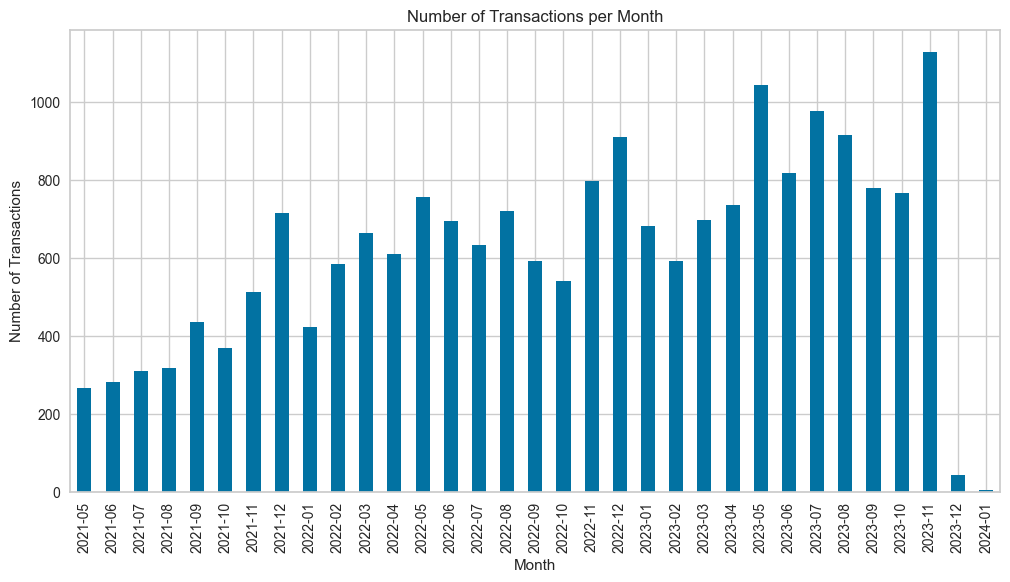

In [8]:
df['paid_at'].dt.to_period('M').value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

## Data Preparation

In [9]:
df_no_missing = df.dropna()

# Print the result
print(df_no_missing)


          total currency             paid_at  user_id  email_id
1054   47300.00      CZK 2021-08-23 13:16:00      9.0      7762
1055   17400.00      CZK 2021-09-07 07:11:00     10.0       885
1056    9209.43      EUR 2021-08-31 07:32:00     15.0     12204
1058   65500.00      CZK 2021-08-18 07:43:00     13.0     12300
1067   61768.00      CZK 2021-08-25 07:30:00      9.0      7762
...         ...      ...                 ...      ...       ...
20265  15081.85      CZK 2023-12-01 10:59:00     12.0     14524
20267  13599.00      CZK 2023-11-30 15:46:00    102.0       695
20272  26099.00      CZK 2023-11-30 18:13:00     19.0     12330
20275  36609.00      CZK 2023-12-01 05:18:00    112.0     15342
20279  95210.00      CZK 2023-12-07 11:23:00      9.0     10919

[2946 rows x 5 columns]


In [10]:
# Create a mapping for email to user_id
email_to_user_id = {}
next_user_id = max(df['user_id'].dropna().astype(int), default=0) + 1  # Start from the next available ID

# Function to get or allocate a user_id based on email
def get_or_allocate_user_id(row):
    global next_user_id
    if pd.isna(row['user_id']):
        email = row['email_id']
        if email not in email_to_user_id:
            email_to_user_id[email] = next_user_id
            next_user_id += 1
        return email_to_user_id[email]
    return row['user_id']

# Apply the function to the DataFrame and save it to a new DataFrame
df_new = df.copy()
df_new['user_id'] = df_new.apply(get_or_allocate_user_id, axis=1)

# Display the new DataFrame
print(df_new)

          total currency             paid_at  user_id  email_id
0      17099.00      CZK 2021-05-31 22:18:00    303.0      1008
1       7099.00      CZK 2021-05-31 22:18:00    304.0      4384
2       9648.00      CZK 2021-05-03 08:07:00    305.0      7707
3       3998.00      CZK 2021-05-31 22:18:00    306.0      7222
4       7397.00      CZK 2021-05-31 22:18:00    307.0      4920
...         ...      ...                 ...      ...       ...
20278  11311.00      CZK 2023-11-30 20:24:00   6508.0      8925
20279  95210.00      CZK 2023-12-07 11:23:00      9.0     10919
20280   4367.99      CZK 2023-11-30 20:00:00  15453.0      4689
20281   4208.00      CZK 2023-11-30 21:53:00  15454.0      6406
20282   4408.00      CZK 2023-11-30 20:02:00  15455.0      7774

[20283 rows x 5 columns]


In [11]:
# Drop the email_id column
df_new = df_new.drop(columns=['email_id'])

# Display the new DataFrame
print(df_new)

          total currency             paid_at  user_id
0      17099.00      CZK 2021-05-31 22:18:00    303.0
1       7099.00      CZK 2021-05-31 22:18:00    304.0
2       9648.00      CZK 2021-05-03 08:07:00    305.0
3       3998.00      CZK 2021-05-31 22:18:00    306.0
4       7397.00      CZK 2021-05-31 22:18:00    307.0
...         ...      ...                 ...      ...
20278  11311.00      CZK 2023-11-30 20:24:00   6508.0
20279  95210.00      CZK 2023-12-07 11:23:00      9.0
20280   4367.99      CZK 2023-11-30 20:00:00  15453.0
20281   4208.00      CZK 2023-11-30 21:53:00  15454.0
20282   4408.00      CZK 2023-11-30 20:02:00  15455.0

[20283 rows x 4 columns]


In [12]:
# Verifying the removal of missing values
df_new.isnull().sum()

total       0
currency    0
paid_at     0
user_id     0
dtype: int64

In [13]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df_new[df_new.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['total', 'currency', 'paid_at', 'user_id'])

# Displaying the first 10 records
duplicate_rows_sorted.head(20)

,total,currency,paid_at,user_id
10790,703.5,EUR,2022-12-19 13:38:00,108.0
10791,703.5,EUR,2022-12-19 13:38:00,108.0
1683,9738.0,CZK,2021-10-07 06:31:00,1794.0
1709,9738.0,CZK,2021-10-07 06:31:00,1794.0
4814,15337.0,CZK,2022-04-01 06:06:00,4285.0
4823,15337.0,CZK,2022-04-01 06:06:00,4285.0
3061,18559.0,CZK,2021-12-20 06:49:00,17.0
3062,18559.0,CZK,2021-12-20 06:49:00,17.0


In [14]:
# Getting the number of rows in the dataframe
print("Number of rows in the dataframe:")
df_new.shape[0]

Number of rows in the dataframe:


20283

In [15]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df_new.drop_duplicates(inplace=True)

The dataset contains 4 duplicate rows that need to be removed.


In [16]:
# Getting the number of rows in the dataframe
print("Number of rows in the dataframe:")
df_new.shape[0]

Number of rows in the dataframe:


20279

In [17]:
# Get the timeframe of the data
timeframe_start = df_new['paid_at'].min()
timeframe_end = df_new['paid_at'].max()

# Get the number of unique user_id values
num_unique_user_id = df_new['user_id'].nunique()

# Print the results
print(f"Timeframe of the data: {timeframe_start} to {timeframe_end}")
print(f"Number of customers: {num_unique_user_id}")

Timeframe of the data: 2021-05-03 08:07:00 to 2024-01-24 15:03:00
Number of customers: 15253


In [18]:
# Get currency value counts
currency_counts = df_new['currency'].value_counts()

# Print the results
print(currency_counts)

currency
CZK    20098
EUR      181
Name: count, dtype: int64


In [19]:
eur_rows = df_new.query('currency == "EUR"')
print(eur_rows)

        total currency             paid_at  user_id
43     113.00      EUR 2021-05-18 08:33:00    346.0
106    467.76      EUR 2021-05-31 22:18:00    409.0
334    111.94      EUR 2021-06-08 10:57:00    630.0
337      1.00      EUR 2021-06-10 12:20:00    633.0
444    667.94      EUR 2021-07-01 10:30:00    736.0
...       ...      ...                 ...      ...
19365  830.00      EUR 2023-11-08 13:30:00  14804.0
19372  872.67      EUR 2023-11-07 17:56:00  14808.0
19433  281.47      EUR 2023-11-13 10:52:00    108.0
19760  203.92      EUR 2023-11-19 18:28:00  15088.0
20044  273.46      EUR 2023-11-30 08:43:00    108.0

[181 rows x 4 columns]


Conversion of the transactions payed in euros to czech crowns 

In [20]:
df_new['total'].describe()

count     20279.000000
mean      10959.555431
std       21501.351529
min           0.000000
25%        2158.000000
50%        4966.000000
75%       11753.250000
max      805000.000000
Name: total, dtype: float64

In [21]:
exchange_rate_eur_to_czk = 25.36

def convert_to_czk(row, exchange_rate):
    if row['currency'] == 'EUR':
        row['total'] = row['total'] * exchange_rate
        row['currency'] = 'CZK'
    return row

# Apply the function to convert totals to CZK and update the 'total' and 'Currency' columns
df_new = df_new.apply(lambda row: convert_to_czk(row, exchange_rate_eur_to_czk), axis=1)

# Display the DataFrame
print(df_new)

          total currency             paid_at  user_id
0      17099.00      CZK 2021-05-31 22:18:00    303.0
1       7099.00      CZK 2021-05-31 22:18:00    304.0
2       9648.00      CZK 2021-05-03 08:07:00    305.0
3       3998.00      CZK 2021-05-31 22:18:00    306.0
4       7397.00      CZK 2021-05-31 22:18:00    307.0
...         ...      ...                 ...      ...
20278  11311.00      CZK 2023-11-30 20:24:00   6508.0
20279  95210.00      CZK 2023-12-07 11:23:00      9.0
20280   4367.99      CZK 2023-11-30 20:00:00  15453.0
20281   4208.00      CZK 2023-11-30 21:53:00  15454.0
20282   4408.00      CZK 2023-11-30 20:02:00  15455.0

[20279 rows x 4 columns]


In [22]:
eur_rows = df_new.query('currency == "EUR"')
print(eur_rows)

Empty DataFrame
Columns: [total, currency, paid_at, user_id]
Index: []


In [23]:
# Removing records with a unit price of zero to avoid potential data entry errors
df_new = df_new[df_new['total'] > 0]

In [24]:
# Resetting the index of the cleaned dataset
df_new.reset_index(drop=True, inplace=True)

In [25]:
# Getting the number of rows in the dataframe
df_new.shape[0]

20278

In [26]:
df_new['total'].describe()

count     20278.000000
mean      11348.744933
std       23569.970540
min           1.000000
25%        2208.000000
50%        5136.475000
75%       11966.000000
max      805000.000000
Name: total, dtype: float64

In [27]:
df_new.head()

,total,currency,paid_at,user_id
0,17099.0,CZK,2021-05-31 22:18:00,303.0
1,7099.0,CZK,2021-05-31 22:18:00,304.0
2,9648.0,CZK,2021-05-03 08:07:00,305.0
3,3998.0,CZK,2021-05-31 22:18:00,306.0
4,7397.0,CZK,2021-05-31 22:18:00,307.0


In [28]:
# Convert paid_at to datetime type
df_new['paid_at'] = pd.to_datetime(df_new['paid_at'], format='%d.%m.%Y %H:%M')

# Extract only the date from paid_at in df_new
df_new['InvoiceDay'] = df_new['paid_at'].dt.date

# Find the most recent purchase date for each customer
recent_purchase = df_new.groupby('user_id')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df_new['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
recent_purchase['InvoiceDay'] = pd.to_datetime(recent_purchase['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
recent_purchase['Days_Since_Last_Purchase'] = (most_recent_date - recent_purchase['InvoiceDay']).dt.days

# Drop the InvoiceDay column
recent_purchase.drop(columns=['InvoiceDay'], inplace=True)

In [29]:
# Calculate the total number of transactions made by each customer
total_transactions = df_new.groupby('user_id').size().reset_index(name='Total_Transactions')

# Calculate the total spend by each customer
total_spend = df_new.groupby('user_id')['total'].sum().reset_index()
total_spend.rename(columns={'total': 'Total_Spend'}, inplace=True)

In [30]:
# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='user_id')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Initialize customer_data with unique user_ids
customer_data = df_new[['user_id']].drop_duplicates().copy()

# Merge all features into the customer_data dataframe
customer_data = pd.merge(customer_data, recent_purchase, on='user_id', how='left')
customer_data = pd.merge(customer_data, total_transactions, on='user_id', how='left')
customer_data = pd.merge(customer_data, total_spend, on='user_id', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['user_id', 'Average_Transaction_Value']], on='user_id', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,user_id,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value
0,303.0,968,1,17099.0,17099.000000
1,304.0,968,1,7099.0,7099.000000
2,305.0,306,3,26824.0,8941.333333
3,306.0,968,1,3998.0,3998.000000
4,307.0,968,1,7397.0,7397.000000


In [31]:
# Convert paid_at to datetime type
df_new['paid_at'] = pd.to_datetime(df_new['paid_at'], format='%d.%m.%Y %H:%M')

# Extract only the date from paid_at in df_new
df_new['InvoiceDay'] = df_new['paid_at'].dt.date

# Extract day of week and hour from paid_at
df_new['Day_Of_Week'] = df_new['paid_at'].dt.dayofweek
df_new['Hour'] = df_new['paid_at'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df_new.groupby('user_id')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('user_id').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df_new.groupby(['user_id', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('user_id')['Count'].idxmax()][['user_id', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df_new.groupby(['user_id', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('user_id')['Count'].idxmax()][['user_id', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='user_id', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='user_id', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='user_id', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\natal\AppData\Local\Temp\ipykernel_14588\703774283.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df_new.groupby('user_id')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,user_id,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,303.0,968,1,17099.0,17099.000000,NaN,0,22
1,304.0,968,1,7099.0,7099.000000,NaN,0,22
2,305.0,306,3,26824.0,8941.333333,345.0,0,6
3,306.0,968,1,3998.0,3998.000000,NaN,0,22
4,307.0,968,1,7397.0,7397.000000,NaN,0,22


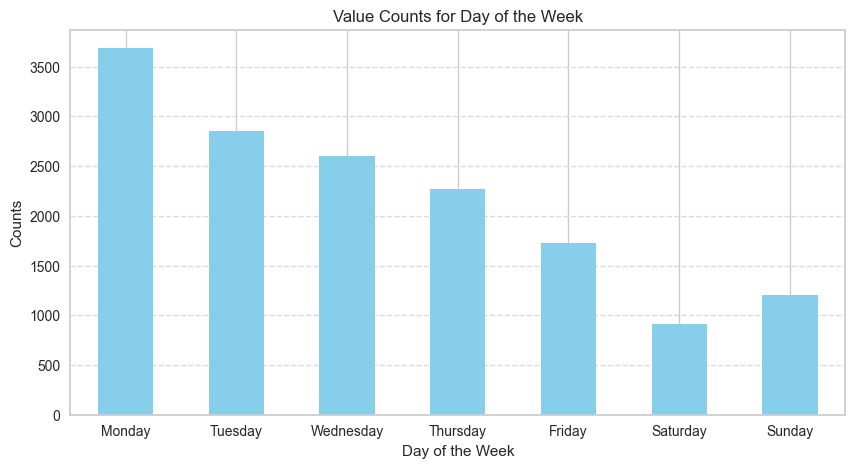

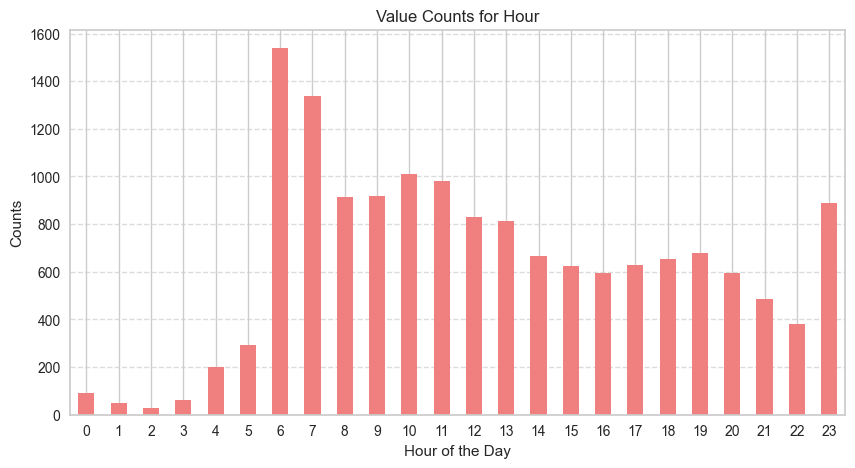

In [32]:
# Display value counts for Day_Of_Week
day_of_week_counts = customer_data['Day_Of_Week'].value_counts().sort_index()

# Map day of week integers to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts.index = day_of_week_counts.index.map(lambda x: day_names[x])

# Plotting Day_Of_Week counts
plt.figure(figsize=(10, 5))
day_of_week_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts for Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display value counts for Hour, ordered by hour
hour_counts = customer_data['Hour'].value_counts().sort_index()

# Plotting Hour counts
plt.figure(figsize=(10, 5))
hour_counts.plot(kind='bar', color='lightcoral')
plt.title('Value Counts for Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
# Fill NaN values with 0 in the 'Average_Days_Between_Purchases' column
customer_data.loc[:, 'Average_Days_Between_Purchases'] = customer_data['Average_Days_Between_Purchases'].fillna(0)

# Verifying the removal of missing values
missing_values_count = customer_data.isnull().sum()
print(missing_values_count)

# Rename user_id to customer_id
customer_data.rename(columns={'user_id': 'Customer_id'}, inplace=True)

# Display the first 10 rows of the customer_data DataFrame
customer_data.head(10)

user_id                           0
Days_Since_Last_Purchase          0
Total_Transactions                0
Total_Spend                       0
Average_Transaction_Value         0
Average_Days_Between_Purchases    0
Day_Of_Week                       0
Hour                              0
dtype: int64


,Customer_id,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,303.0,968,1,17099.0,17099.000000,0.0,0,22
1,304.0,968,1,7099.0,7099.000000,0.0,0,22
2,305.0,306,3,26824.0,8941.333333,345.0,0,6
3,306.0,968,1,3998.0,3998.000000,0.0,0,22
4,307.0,968,1,7397.0,7397.000000,0.0,0,22
5,308.0,996,1,12099.0,12099.000000,0.0,0,8
6,309.0,968,1,3499.0,3499.000000,0.0,0,22
7,310.0,968,1,10799.0,10799.000000,0.0,0,22
8,311.0,996,1,12837.0,12837.000000,0.0,0,8
9,312.0,996,1,19999.0,19999.000000,0.0,0,8


In [34]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['Customer_id'] = customer_data['Customer_id'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,Customer_id,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,303.0,968,1,17099.0,17099.0,0.0,0,22
1,304.0,968,1,7099.0,7099.0,0.0,0,22
2,305.0,306,3,26824.0,8941.333333,345.0,0,6
3,306.0,968,1,3998.0,3998.0,0.0,0,22
4,307.0,968,1,7397.0,7397.0,0.0,0,22
5,308.0,996,1,12099.0,12099.0,0.0,0,8
6,309.0,968,1,3499.0,3499.0,0.0,0,22
7,310.0,968,1,10799.0,10799.0,0.0,0,22
8,311.0,996,1,12837.0,12837.0,0.0,0,8
9,312.0,996,1,19999.0,19999.0,0.0,0,8


In [35]:
# Getting the number of rows in the dataframe
customer_data.shape[0]

15252

In [36]:
# Getting the number of rows in the dataframe
customer_data.shape[0]

15252

In [37]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15252 entries, 0 to 15251
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_id                     15252 non-null  string 
 1   Days_Since_Last_Purchase        15252 non-null  Int64  
 2   Total_Transactions              15252 non-null  Int64  
 3   Total_Spend                     15252 non-null  Float64
 4   Average_Transaction_Value       15252 non-null  Float64
 5   Average_Days_Between_Purchases  15252 non-null  Float64
 6   Day_Of_Week                     15252 non-null  Int32  
 7   Hour                            15252 non-null  Int32  
dtypes: Float64(3), Int32(2), Int64(2), string(1)
memory usage: 938.5 KB


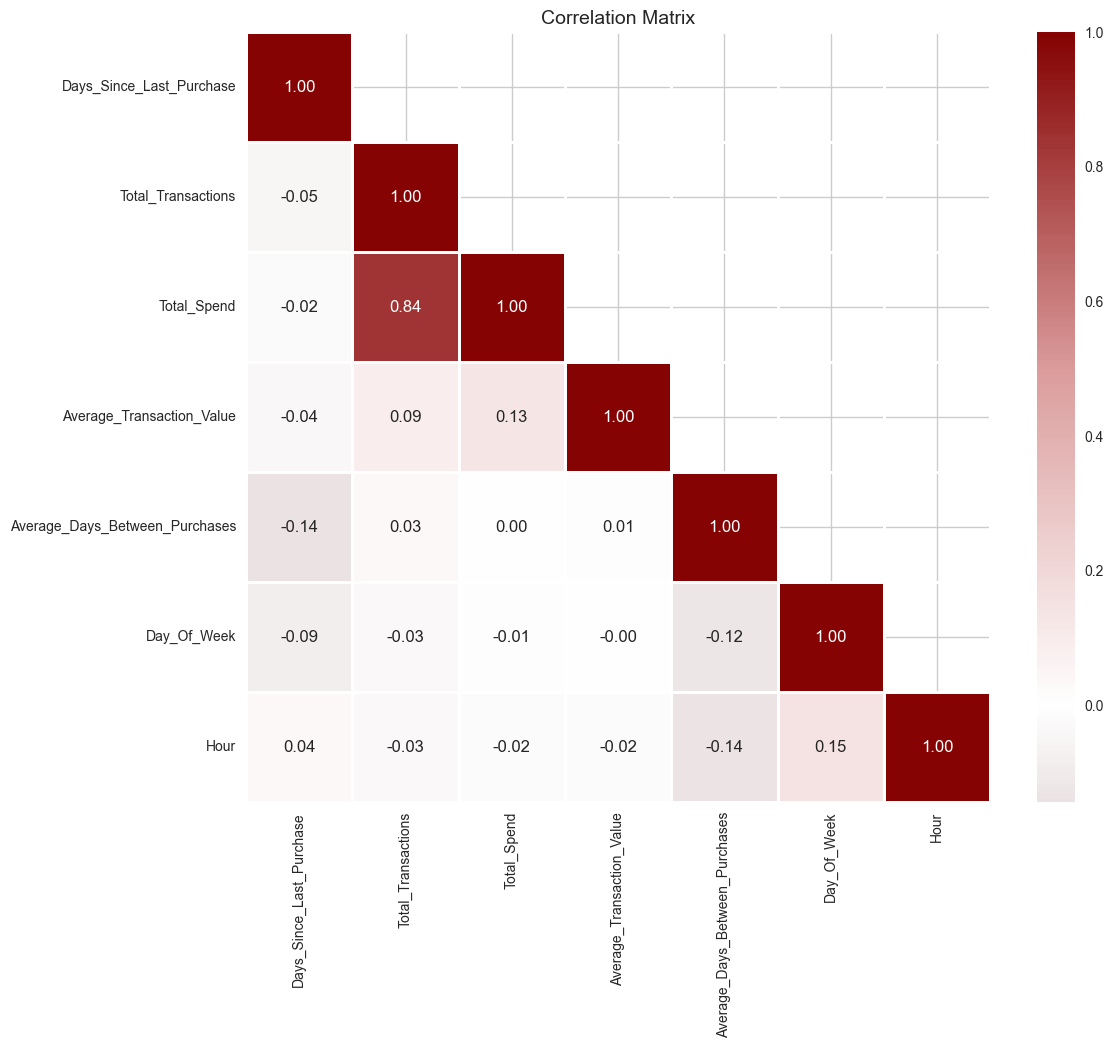

In [38]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data.drop(columns=['Customer_id']).corr()

# Define a custom colormap
colors = ['#fa9d9d', '#ba9e9e', 'white', '#db9c9c', '#850303']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [39]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer_id', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,Customer_id,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,303.0,2.047816,-0.049668,0.004422,1.030415,-0.239877,0,1.673669
1,304.0,2.047816,-0.049668,-0.017572,0.021472,-0.239877,0,1.673669
2,305.0,-0.538344,0.251780,0.025811,0.207353,3.983732,0,-1.182517
3,306.0,2.047816,-0.049668,-0.024392,-0.291401,-0.239877,0,1.673669
4,307.0,2.047816,-0.049668,-0.016916,0.051538,-0.239877,0,1.673669


In [40]:
from datetime import datetime, timedelta

this_date = datetime(2024, 1, 24)

# Convert Days_Since_Last_Purchase to LastPurchaseDate
customer_data['LastPurchaseDate'] = customer_data['Days_Since_Last_Purchase'].apply(
    lambda x: this_date - timedelta(days=x))

# Create df_recency DataFrame with Customer ID and Recency
df_recency = customer_data[['Customer_id', 'Days_Since_Last_Purchase']].copy()
df_recency = df_recency.rename(columns={'Days_Since_Last_Purchase': 'Recency'})


# Display the resulting DataFrame
df_recency.head()

,Customer_id,Recency
0,303.0,968
1,304.0,968
2,305.0,306
3,306.0,968
4,307.0,968


In [41]:
df_recency.describe()

,Recency
count,15252.0
mean,443.804157
std,255.986442
min,0.0
25%,221.0
50%,419.0
75%,649.0
max,996.0


In [42]:
# Drop duplicates and calculate frequency
frequency_df = customer_data.drop_duplicates().groupby(
    by=['Customer_id'], as_index=False)['Total_Transactions'].sum()
frequency_df.columns = ['Customer_id', 'Frequency']

frequency_df.head()

,Customer_id,Frequency
0,1.0,10
1,10.0,75
2,1000.0,1
3,10000.0,1
4,10001.0,1


In [43]:
frequency_df.describe()

,Frequency
count,15252.0
mean,1.329531
std,6.63485
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,586.0


In [44]:
#Calculating Monetary Value 
monetary_df =customer_data.groupby(by='Customer_id', as_index=False)['Total_Spend'].sum()
monetary_df.columns = ['Customer_id', "Monetary"]
monetary_df.head()

,Customer_id,Monetary
0,1.0,108097.85
1,10.0,2259409.3
2,1000.0,11299.0
3,10000.0,2218.0
4,10001.0,4407.0


In [45]:
monetary_df.describe()

,Monetary
count,15252.0
mean,15088.50313
std,454691.903652
min,1.0
25%,2201.5225
50%,4578.0
75%,10686.0
max,54048322.83


In [46]:
# Ensure all Customer ID columns are of type string
df_recency['Customer_id'] = df_recency['Customer_id'].astype(str)
frequency_df['Customer_id'] = frequency_df['Customer_id'].astype(str)
monetary_df['Customer_id'] = monetary_df['Customer_id'].astype(str)

# Merge the dataframes
rf_df = df_recency.merge(frequency_df, on='Customer_id')
rfm_df = rf_df.merge(monetary_df, on='Customer_id')

rfm_df.head()

,Customer_id,Recency,Frequency,Monetary
0,303.0,968,1,17099.0
1,304.0,968,1,7099.0
2,305.0,306,3,26824.0
3,306.0,968,1,3998.0
4,307.0,968,1,7397.0


In [47]:
# Display the unique values in the 'Frequency' column and their counts
frequency_values_counts = rfm_df['Frequency'].value_counts().sort_index()

# Calculate the percentage of each value
frequency_values_percentage = (frequency_values_counts / frequency_values_counts.sum()) * 100

# Combine counts and percentages into a DataFrame
frequency_stats = pd.DataFrame({'Count': frequency_values_counts, 'Percentage': frequency_values_percentage})

# Print the unique values, their counts, and percentages
print(frequency_stats)


           Count  Percentage
Frequency                   
1          13443    88.13926
2           1445    9.474167
3            223    1.462103
4             60    0.393391
5             20     0.13113
6              8    0.052452
7              7    0.045896
8              5    0.032783
9              2    0.013113
10             1    0.006557
12             1    0.006557
13             2    0.013113
14             2    0.013113
15             1    0.006557
17             2    0.013113
18             1    0.006557
22             1    0.006557
23             1    0.006557
28             1    0.006557
29             1    0.006557
31             1    0.006557
32             1    0.006557
33             1    0.006557
37             1    0.006557
39             1    0.006557
41             1    0.006557
45             3     0.01967
47             1    0.006557
48             1    0.006557
53             1    0.006557
58             1    0.006557
59             1    0.006557
60            

## Modelling

### RFM

In [48]:
# Calculate quantiles for Recency, Frequency, and Monetary
quantiles_recency = rfm_df['Recency'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
quantiles_frequency = rfm_df['Frequency'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
quantiles_monetary = rfm_df['Monetary'].quantile([0.2, 0.4, 0.6, 0.8]).tolist()

# Assign scores based on quantiles
def assign_rfm_scores_quantiles(recency, frequency, monetary):
    # Assign Recency score
    if recency <= quantiles_recency[0]:
        r_score = 5
    elif recency <= quantiles_recency[1]:
        r_score = 4
    elif recency <= quantiles_recency[2]:
        r_score = 3
    elif recency <= quantiles_recency[3]:
        r_score = 2
    else:
        r_score = 1

    # Assign Frequency score
    if frequency <= quantiles_frequency[0]:
        f_score = 1
    elif frequency <= quantiles_frequency[1]:
        f_score = 2
    elif frequency <= quantiles_frequency[2]:
        f_score = 3
    elif frequency <= quantiles_frequency[3]:
        f_score = 4
    else:
        f_score = 5

    # Assign Monetary score
    if monetary <= quantiles_monetary[0]:
        m_score = 1
    elif monetary <= quantiles_monetary[1]:
        m_score = 2
    elif monetary <= quantiles_monetary[2]:
        m_score = 3
    elif monetary <= quantiles_monetary[3]:
        m_score = 4
    else:
        m_score = 5

    return r_score, f_score, m_score

# Apply the function to the DataFrame
rfm_df[['R_Score', 'F_Score', 'M_Score']] = rfm_df.apply(lambda x: assign_rfm_scores_quantiles(x['Recency'], x['Frequency'], x['Monetary']), axis=1, result_type='expand')
rfm_df.head()



,Customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,303.0,968,1,17099.0,1,1,5
1,304.0,968,1,7099.0,1,1,4
2,305.0,306,3,26824.0,4,5,5
3,306.0,968,1,3998.0,1,1,3
4,307.0,968,1,7397.0,1,1,4


In [49]:
# Normalizing Recency
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['R_rank_norm'] = (rfm_df['R_rank'] / rfm_df['R_rank'].max()) * 100

# Normalizing Frequency
rfm_df['F_rank'] = rfm_df['F_Score'].rank(ascending=False)
rfm_df['F_rank_norm'] = (rfm_df['F_Score'] / rfm_df['F_Score'].max()) * 100

# Normalizing Monetary
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
rfm_df['M_rank_norm'] = (rfm_df['M_rank'] / rfm_df['M_rank'].max()) * 100


# Dropping intermediate columns used for normalization
rfm_df.drop(columns=['R_rank', 'M_rank'], inplace=True)

# Assign quintile-based scores (1 to 5) based on normalized ranks
bins = [0, 20, 40, 60, 80, 100]
labels = [1, 2, 3, 4, 5]

# Combine the R, F, M scores into a single column
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Combine the R, F, M scores into a single numerical score
rfm_df['RFM_Combined'] = rfm_df['R_Score'].astype(int) + rfm_df['F_Score'].astype(int) + rfm_df['M_Score'].astype(int)

# Display the updated DataFrame
rfm_df.head(10)


,Customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_rank_norm,F_rank,F_rank_norm,M_rank_norm,RFM_Score,RFM_Combined
0,303.0,968,1,17099.0,1,1,5,0.996591,8531.0,20.0,89.129295,115,7
1,304.0,968,1,7099.0,1,1,4,0.996591,8531.0,20.0,60.218332,114,6
2,305.0,306,3,26824.0,4,5,5,63.313008,905.0,100.0,96.813533,455,14
3,306.0,968,1,3998.0,1,1,3,0.996591,8531.0,20.0,43.184500,113,5
4,307.0,968,1,7397.0,1,1,4,0.996591,8531.0,20.0,61.205088,114,6
5,308.0,996,1,12099.0,1,1,4,0.013113,8531.0,20.0,78.802780,114,6
6,309.0,968,1,3499.0,1,1,2,0.996591,8531.0,20.0,38.270391,112,4
7,310.0,968,1,10799.0,1,1,4,0.996591,8531.0,20.0,75.373721,114,6
8,311.0,996,1,12837.0,1,1,5,0.013113,8531.0,20.0,80.455022,115,7
9,312.0,996,1,19999.0,1,1,5,0.013113,8531.0,20.0,92.718988,115,7


In [50]:
# Define the function to assign segments based on RFM_Combined score
def assign_segment(rfm_combined):
    if rfm_combined >= 13:
        return 'Champions'
    elif rfm_combined >= 10:
        return 'Loyal Customers'
    elif rfm_combined >= 7:
        return 'Potential Loyalist'
    elif rfm_combined >= 5:
        return 'Promising'
    elif rfm_combined == 4:
        return 'At Risk'
    else:
        return 'Hibernating'

# Apply the function to the RFM_Combined column to create a new column for Customer Segment
rfm_df['Customer_Segment'] = rfm_df['RFM_Combined'].apply(assign_segment)

# Display the updated DataFrame
rfm_df.head(10)

,Customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_rank_norm,F_rank,F_rank_norm,M_rank_norm,RFM_Score,RFM_Combined,Customer_Segment
0,303.0,968,1,17099.0,1,1,5,0.996591,8531.0,20.0,89.129295,115,7,Potential Loyalist
1,304.0,968,1,7099.0,1,1,4,0.996591,8531.0,20.0,60.218332,114,6,Promising
2,305.0,306,3,26824.0,4,5,5,63.313008,905.0,100.0,96.813533,455,14,Champions
3,306.0,968,1,3998.0,1,1,3,0.996591,8531.0,20.0,43.184500,113,5,Promising
4,307.0,968,1,7397.0,1,1,4,0.996591,8531.0,20.0,61.205088,114,6,Promising
5,308.0,996,1,12099.0,1,1,4,0.013113,8531.0,20.0,78.802780,114,6,Promising
6,309.0,968,1,3499.0,1,1,2,0.996591,8531.0,20.0,38.270391,112,4,At Risk
7,310.0,968,1,10799.0,1,1,4,0.996591,8531.0,20.0,75.373721,114,6,Promising
8,311.0,996,1,12837.0,1,1,5,0.013113,8531.0,20.0,80.455022,115,7,Potential Loyalist
9,312.0,996,1,19999.0,1,1,5,0.013113,8531.0,20.0,92.718988,115,7,Potential Loyalist


In [51]:
# Group by 'Segment' and count the number of customers in each segment
customer_segment_counts = rfm_df['Customer_Segment'].value_counts().reset_index()
customer_segment_counts.columns = ['Customer_Segment', 'Number Of Customers']

# Print the segment counts
print(customer_segment_counts)

     Customer_Segment  Number Of Customers
0  Potential Loyalist                 5751
1           Promising                 4389
2     Loyal Customers                 2207
3             At Risk                 1389
4           Champions                  987
5         Hibernating                  529


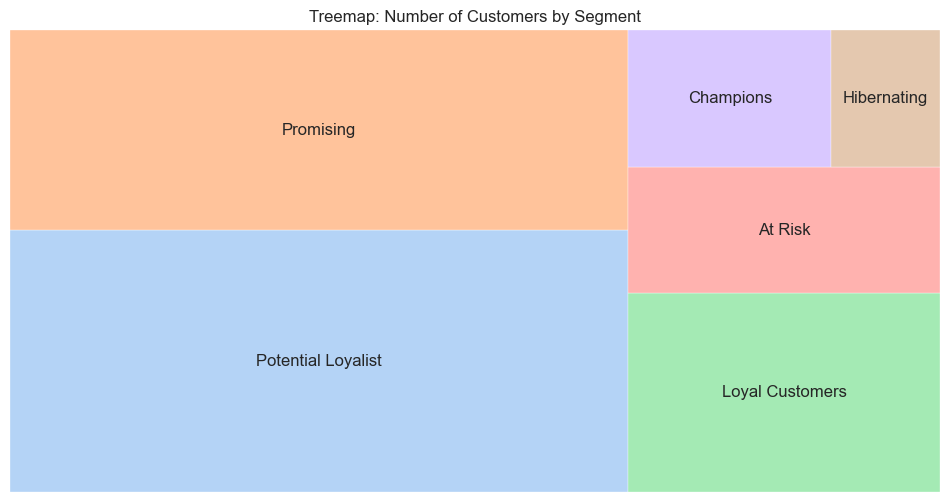

In [52]:
# Group by 'Segment' and count the number of customers in each segment
customer_segment_counts = rfm_df['Customer_Segment'].value_counts().reset_index()
customer_segment_counts.columns = ['Customer_Segment', 'NumberOfCustomers']

# Get a color palette from seaborn
palette = sns.color_palette("pastel", len(customer_segment_counts))

# Create a treemap with custom colors
plt.figure(figsize=(12, 6))
squarify.plot(sizes=customer_segment_counts['NumberOfCustomers'], label=customer_segment_counts['Customer_Segment'], color=palette, alpha=.8)
plt.axis('off')
plt.title('Treemap: Number of Customers by Segment')
plt.show()


In [53]:
customer_segment_counts = rfm_df['Customer_Segment'].value_counts()

# Display the counts
print(customer_segment_counts)

Customer_Segment
Potential Loyalist    5751
Promising             4389
Loyal Customers       2207
At Risk               1389
Champions              987
Hibernating            529
Name: count, dtype: int64


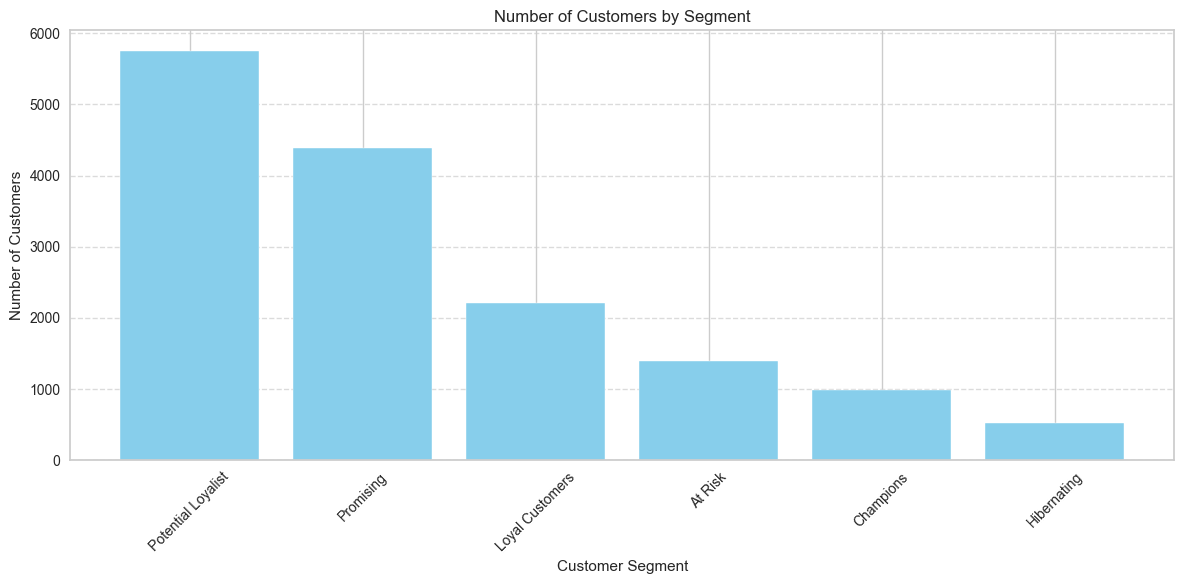

In [54]:
# Calculate the counts of customers in each segment
segment_counts = rfm_df['Customer_Segment'].value_counts().reset_index()
segment_counts.columns = ['Customer_Segment', 'NumberOfCustomers']

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(segment_counts['Customer_Segment'], segment_counts['NumberOfCustomers'], color='skyblue')
plt.title('Number of Customers by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
rfm_df.describe()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_rank_norm,F_rank,F_rank_norm,M_rank_norm,RFM_Combined
count,15252.0,15252.0,15252.0,15252.000000,15252.000000,15252.00000,15252.000000,15252.000000,15252.000000,15252.000000,15252.000000
mean,443.804157,1.329531,15088.50313,3.002688,1.474430,2.99541,50.003278,7626.500000,29.488592,50.003278,7.472528
std,255.986442,6.63485,454691.903652,1.414512,1.293346,1.41717,28.868397,2465.764666,25.866925,28.868338,2.746204
min,0.0,1.0,1.0,1.000000,1.000000,1.00000,0.013113,905.000000,20.000000,0.013113,3.000000
25%,221.0,1.0,2201.5225,2.000000,1.000000,2.00000,25.013113,8531.000000,20.000000,25.007376,5.000000
50%,419.0,1.0,4578.0,3.000000,1.000000,3.00000,49.960661,8531.000000,20.000000,50.003278,7.000000
75%,649.0,1.0,10686.0,4.000000,1.000000,4.00000,74.973774,8531.000000,20.000000,75.000000,9.000000
max,996.0,586.0,54048322.83,5.000000,5.000000,5.00000,100.000000,8531.000000,100.000000,100.000000,15.000000


In [56]:
rfm_df.head(10)

,Customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_rank_norm,F_rank,F_rank_norm,M_rank_norm,RFM_Score,RFM_Combined,Customer_Segment
0,303.0,968,1,17099.0,1,1,5,0.996591,8531.0,20.0,89.129295,115,7,Potential Loyalist
1,304.0,968,1,7099.0,1,1,4,0.996591,8531.0,20.0,60.218332,114,6,Promising
2,305.0,306,3,26824.0,4,5,5,63.313008,905.0,100.0,96.813533,455,14,Champions
3,306.0,968,1,3998.0,1,1,3,0.996591,8531.0,20.0,43.184500,113,5,Promising
4,307.0,968,1,7397.0,1,1,4,0.996591,8531.0,20.0,61.205088,114,6,Promising
5,308.0,996,1,12099.0,1,1,4,0.013113,8531.0,20.0,78.802780,114,6,Promising
6,309.0,968,1,3499.0,1,1,2,0.996591,8531.0,20.0,38.270391,112,4,At Risk
7,310.0,968,1,10799.0,1,1,4,0.996591,8531.0,20.0,75.373721,114,6,Promising
8,311.0,996,1,12837.0,1,1,5,0.013113,8531.0,20.0,80.455022,115,7,Potential Loyalist
9,312.0,996,1,19999.0,1,1,5,0.013113,8531.0,20.0,92.718988,115,7,Potential Loyalist


### K-means

In [57]:
#Transform data to meet K-means requirement for construction
rfm1=rfm_df[['R_rank_norm','F_rank_norm','M_rank_norm']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[-1.69764517, -0.36683535,  1.35537068],
       [-1.69764517, -0.36683535,  0.35386134],
       [ 0.46106358,  2.72601861,  1.62156162],
       ...,
       [ 1.71854066, -0.36683535, -0.08891958],
       [ 1.71854066, -0.36683535, -0.14695012],
       [ 1.71854066, -0.36683535, -0.05723559]])

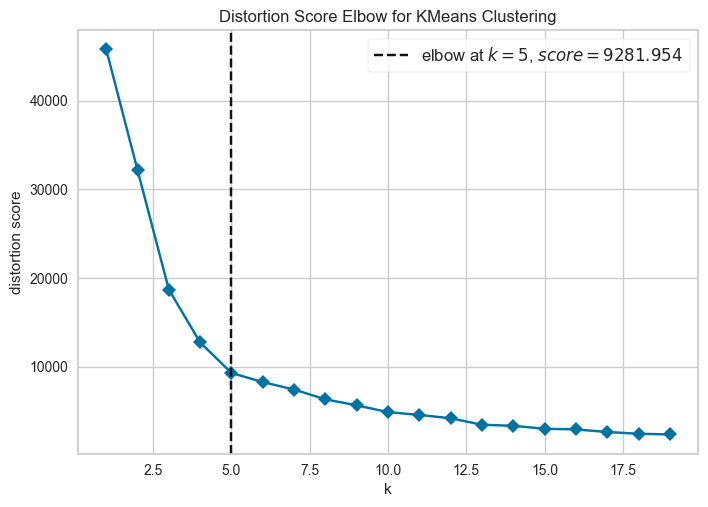

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
# Elbow Method to check the number of k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20), timings=False)  # Disable fit time display
visualizer.fit(x_scaled)  
visualizer.show()

Identified Clusters: [4 4 0 ... 2 2 2]
Our cluster centers are as follows:
[[-0.83675796 -0.36683535 -0.8766222 ]
 [ 0.84534594 -0.36683535  0.74682991]
 [ 0.41175657  2.72601861  0.78020994]
 [ 0.77791649 -0.36683535 -1.01087879]
 [-1.01111262 -0.36683535  0.75183774]]


C:\Users\natal\AppData\Local\Temp\ipykernel_14588\348882472.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(x="cluster_pred", data=clusters_scaled, palette=colors)


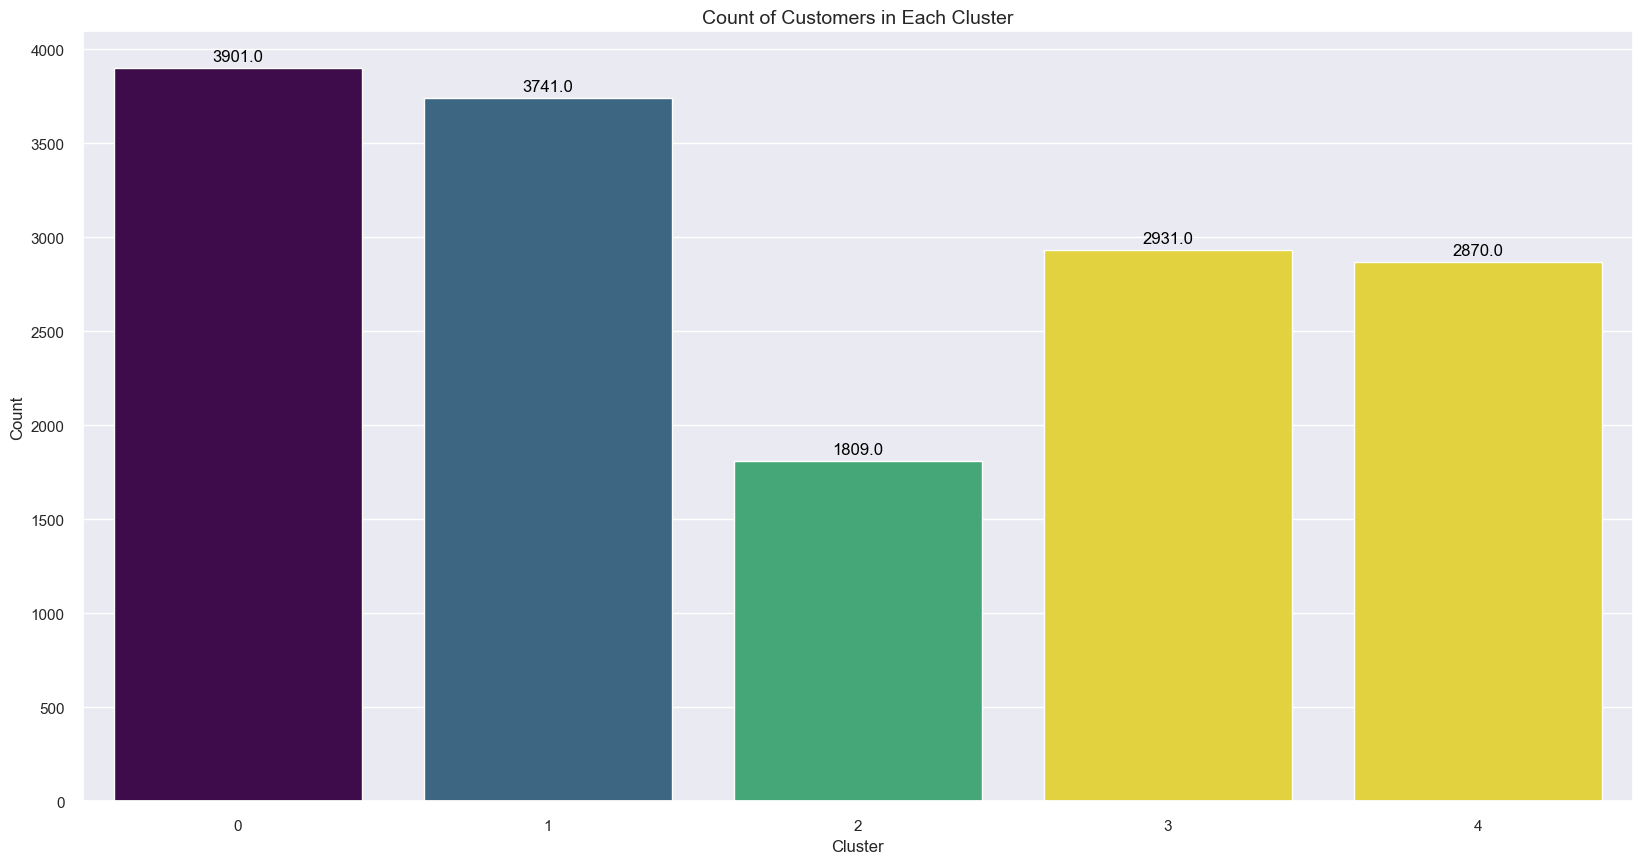

              R_rank_norm  F_rank_norm  M_rank_norm
cluster_pred                                       
0                    3901         3901         3901
1                    3741         3741         3741
2                    1809         1809         1809
3                    2931         2931         2931
4                    2870         2870         2870


In [59]:
#Apply k to form clusters
kmeans_scaled = KMeans(5)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)

# Print the identified clusters and cluster centers
print("Identified Clusters:", identified_clusters)
sns.set(style="darkgrid")
print("Our cluster centers are as follows:")
print(kmeans_scaled.cluster_centers_)

# Extract colors used in the scatter plot
colors = [plt.cm.viridis(i / 3) for i in range(5)]  # Adjust to ensure proper color mapping

# Create a count plot with the same colors as the first graph
f, ax = plt.subplots(figsize=(20, 10))
count_plot = sns.countplot(x="cluster_pred", data=clusters_scaled, palette=colors)

# Adding counts on the bars
for p in count_plot.patches:
    count_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.title('Count of Customers in Each Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Display the groupby results
print(clusters_scaled.groupby(['cluster_pred']).count())

## Evaluation

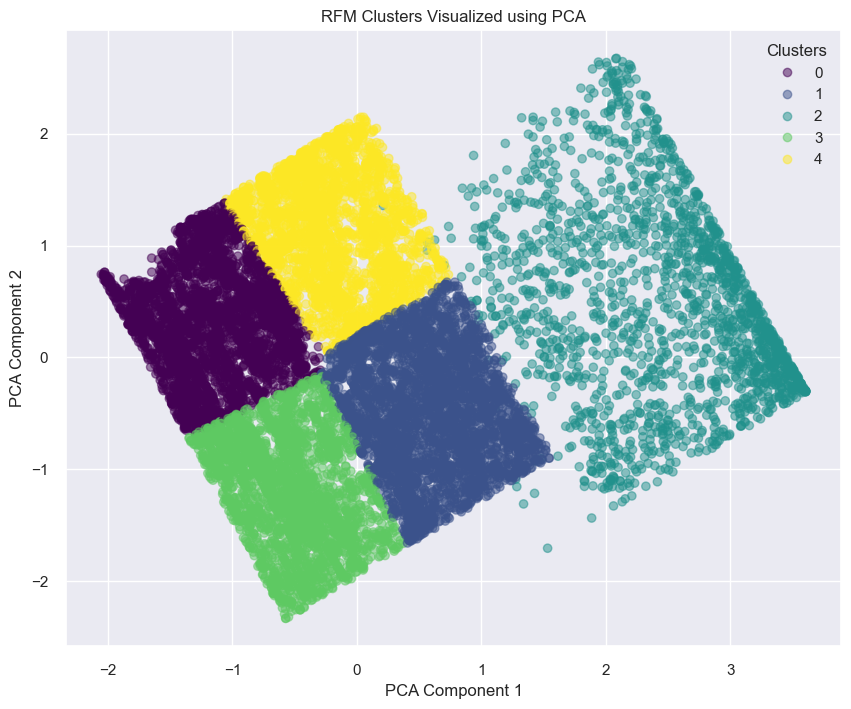

In [60]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(x_scaled)

# Scatter plot of the data points colored by cluster label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters_scaled['cluster_pred'], cmap='viridis', alpha=0.5)
plt.title('RFM Clusters Visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(6), title="Clusters")
plt.show()

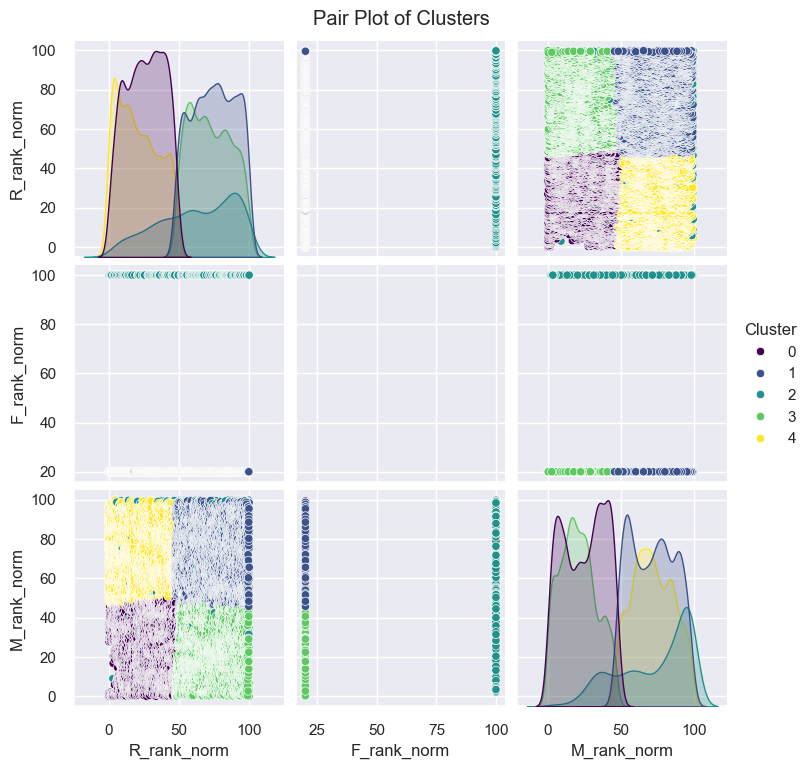

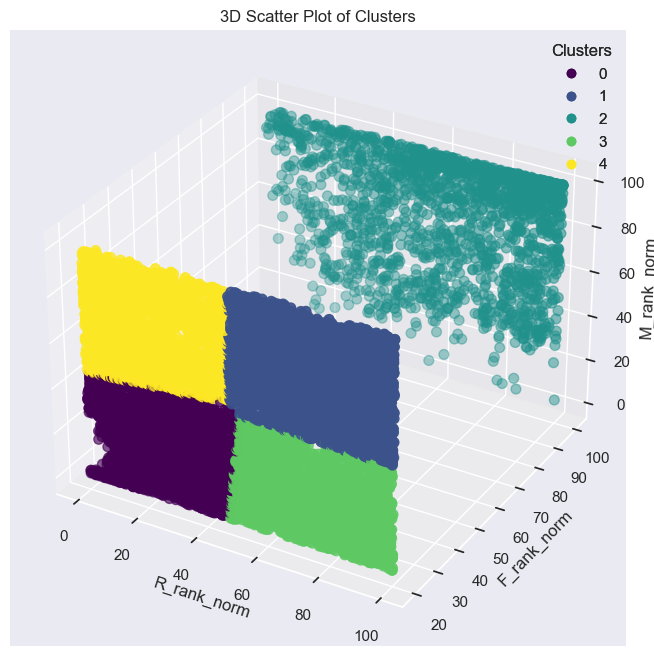

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Add the cluster predictions to the original DataFrame
rfm_df['Cluster'] = clusters_scaled['cluster_pred']

# Pair plot to visualize the distribution of clusters
sns.pairplot(rfm_df, hue='Cluster', vars=['R_rank_norm', 'F_rank_norm', 'M_rank_norm'], palette='viridis')
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

# 3D scatter plot to visualize the clusters in 3D space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm_df['R_rank_norm'], rfm_df['F_rank_norm'], rfm_df['M_rank_norm'],
                     c=rfm_df['Cluster'], cmap='viridis', s=50)

# Adding labels and title
ax.set_xlabel('R_rank_norm')
ax.set_ylabel('F_rank_norm')
ax.set_zlabel('M_rank_norm')
ax.set_title('3D Scatter Plot of Clusters')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

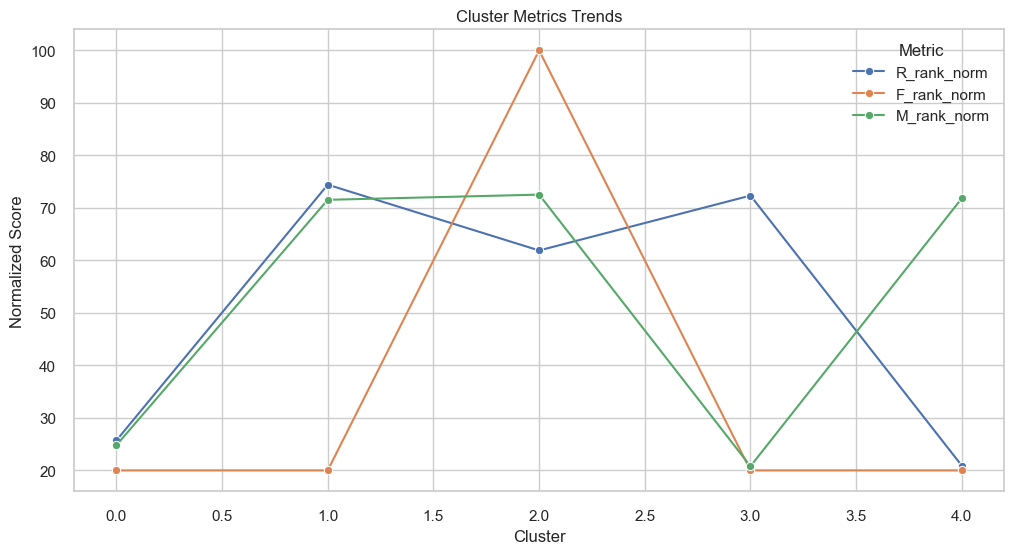

In [62]:
# Calculate the mean R, F, and M scores for each cluster
cluster_metrics = rfm_df.groupby('Cluster').agg({
    'R_rank_norm': 'mean',
    'F_rank_norm': 'mean',
    'M_rank_norm': 'mean'
}).reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
cluster_metrics_melted = cluster_metrics.melt(id_vars='Cluster', var_name='Metric', value_name='Score')

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot the cluster metrics trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_metrics_melted, x='Cluster', y='Score', hue='Metric', marker='o')

# Add titles and labels
plt.title('Cluster Metrics Trends')
plt.xlabel('Cluster')
plt.ylabel('Normalized Score')
plt.legend(title='Metric')

# Show the plot
plt.show()

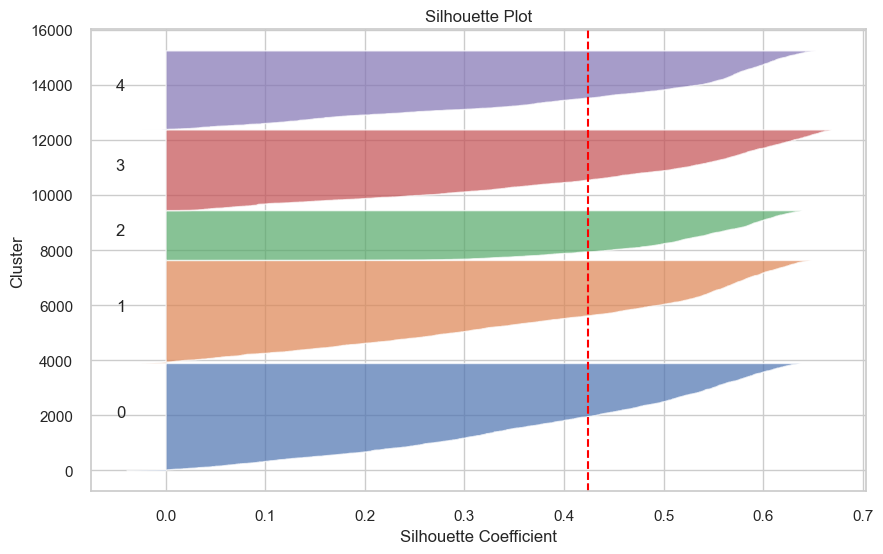

In [63]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette scores
silhouette_vals = silhouette_samples(x_scaled, clusters_scaled['cluster_pred'])

# Silhouette plot
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(kmeans_scaled.n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters_scaled['cluster_pred'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_score(x_scaled, clusters_scaled['cluster_pred']), color="red", linestyle="--")
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.title('Silhouette Plot')
plt.show()


In [64]:
#Basic statistice on Clusters
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['Customer_Segment']=rfm_df['Customer_Segment']
rfm1.groupby('cluster').agg({
    'R_rank_norm' : ['mean','min','max'],
    'F_rank_norm' : ['mean','min','max'],
    'M_rank_norm' : ['mean','min','max','count']
})

C:\Users\natal\AppData\Local\Temp\ipykernel_14588\375003259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['cluster']= clusters_scaled['cluster_pred']
C:\Users\natal\AppData\Local\Temp\ipykernel_14588\375003259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['Customer_Segment']=rfm_df['Customer_Segment']


R_rank_norm                        F_rank_norm                \
               mean        min         max        mean    min    max   
cluster                                                                
0         25.709389   0.036061   50.734330        20.0   20.0   20.0   
1         74.420940  47.633097  100.000000        20.0   20.0   20.0   
2         61.889640   0.278652   99.950826       100.0  100.0  100.0   
3         72.344769  47.633097   99.993443        20.0   20.0   20.0   
4         20.887826   0.013113   47.633097        20.0   20.0   20.0   

        M_rank_norm                               
               mean        min         max count  
cluster                                           
0         24.796338   0.026226   50.380278  3901  
1         71.538861  45.639916   99.888539  3741  
2         72.525904   2.137425  100.000000  1809  
3         20.788596   0.013113   46.892211  2931  
4         71.833404  46.233281   99.809861  2870

In [65]:
#The nature of clusters will be determioned(Homogeneous or herogeneous)
rfm1.groupby(['cluster','Customer_Segment']).size()

cluster  Customer_Segment  
0        At Risk               1389
         Hibernating            529
         Potential Loyalist     144
         Promising             1839
1        Loyal Customers       1478
         Potential Loyalist    2263
2        Champions              987
         Loyal Customers        729
         Potential Loyalist      93
3        Potential Loyalist    1658
         Promising             1273
4        Potential Loyalist    1593
         Promising             1277
dtype: int64

In [66]:
# Extract colors used in the scatter plot
colors = [plt.cm.viridis(i / 3) for i in range(5)]  # Adjust to ensure proper color mapping

# Calculate the percentage of customers in each cluster
cluster_percentage = (clusters_scaled['cluster_pred'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Print the cluster_percentage DataFrame to verify
print(cluster_percentage)

   Cluster  Percentage
0        0   25.576974
1        1   24.527931
4        2   11.860740
2        3   19.217152
3        4   18.817204


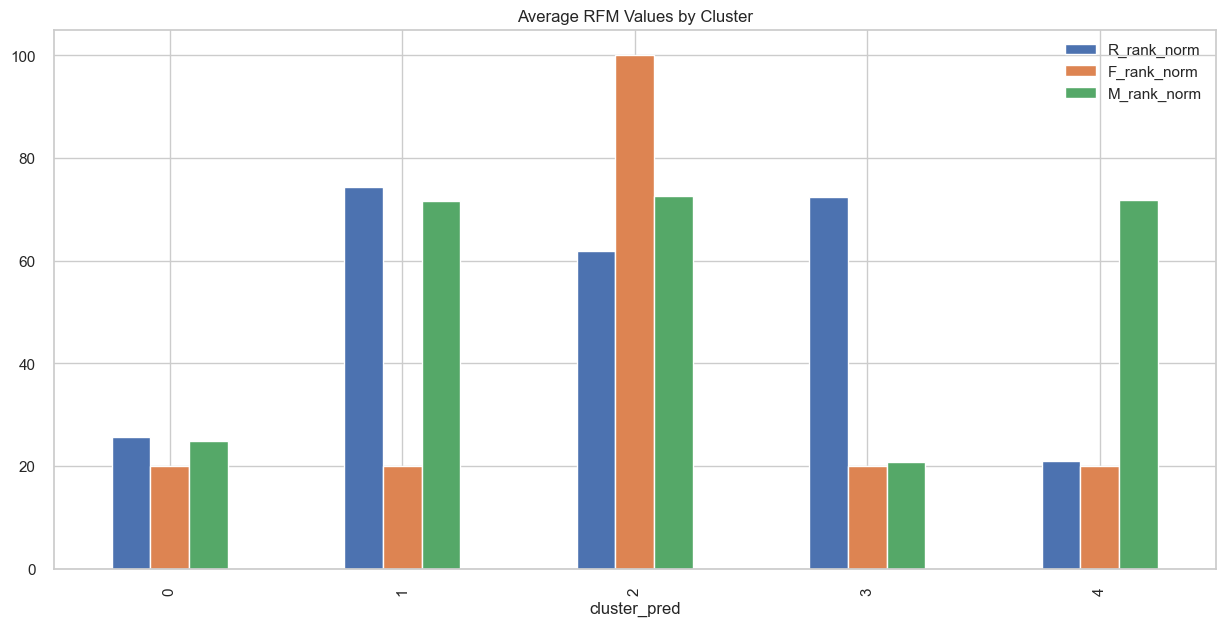

In [67]:
# Visualize the clusters' average RFM values
rfm_means = clusters_scaled.groupby('cluster_pred').mean()
rfm_means.plot(kind='bar', figsize=(15, 7), title="Average RFM Values by Cluster")
plt.show()

In [68]:
# Analysis for Cluster 0
cluster_0 = clusters_scaled[clusters_scaled['cluster_pred'] == 0]
print("Cluster 0 Analysis:")
print(cluster_0.describe())

# Analysis for Cluster 1
cluster_1 = clusters_scaled[clusters_scaled['cluster_pred'] == 1]
print("Cluster 1 Analysis:")
print(cluster_1.describe())

# Analysis for Cluster 2
cluster_2 = clusters_scaled[clusters_scaled['cluster_pred'] == 2]
print("Cluster 2 Analysis:")
print(cluster_2.describe())

# Analysis for Cluster 3
cluster_3 = clusters_scaled[clusters_scaled['cluster_pred'] == 3]
print("Cluster 3 Analysis:")
print(cluster_3.describe())

# Analysis for Cluster 4
cluster_4 = clusters_scaled[clusters_scaled['cluster_pred'] == 4]
print("Cluster 4 Analysis:")
print(cluster_4.describe())

Cluster 0 Analysis:
       R_rank_norm  F_rank_norm  M_rank_norm  cluster_pred
count  3901.000000       3901.0  3901.000000        3901.0
mean     25.709389         20.0    24.796338           0.0
std      13.303477          0.0    14.418801           0.0
min       0.036061         20.0     0.026226           0.0
25%      14.604642         20.0    11.352609           0.0
50%      26.117886         20.0    25.770391           0.0
75%      37.001705         20.0    37.444270           0.0
max      50.734330         20.0    50.380278           0.0
Cluster 1 Analysis:
       R_rank_norm  F_rank_norm  M_rank_norm  cluster_pred
count  3741.000000       3741.0  3741.000000        3741.0
mean     74.420940         20.0    71.538861           1.0
std      15.083481          0.0    15.025879           0.0
min      47.633097         20.0    45.639916           1.0
25%      62.113165         20.0    57.490821           1.0
50%      74.721348         20.0    72.016785           1.0
75%      87.4672

In [69]:
# Display the silhouette score for the K-means clustering
silhouette_avg = silhouette_score(x_scaled, clusters_scaled['cluster_pred'])
print(f"The average silhouette score for K-means clustering is: {silhouette_avg}")

# Display the Calinski-Harabasz Index for the K-means clustering
calinski_harabasz_index = calinski_harabasz_score(x_scaled, clusters_scaled['cluster_pred'])
print(f"The Calinski-Harabasz Index for K-means clustering is: {calinski_harabasz_index}")

# Display the Davies-Bouldin Index for the K-means clustering
davies_bouldin_index = davies_bouldin_score(x_scaled, clusters_scaled['cluster_pred'])
print(f"The Davies-Bouldin Index for K-means clustering is: {davies_bouldin_index}")

The average silhouette score for K-means clustering is: 0.42345672507996657
The Calinski-Harabasz Index for K-means clustering is: 14978.539490323614
The Davies-Bouldin Index for K-means clustering is: 0.7311893567595987
